In [ ]:
import pandas as pd
# from geexhp.model import datasetup as dset

# modern = dset.combine_parquet("../parallel/data", keyword="modern", output_file="modern_data")
# proterozoic = dset.combine_parquet("../parallel/data", keyword="proterozoic", output_file="proterozoic_data")
# archean = dset.combine_parquet("../parallel/data", keyword="archean", output_file="archean_data")
# random = dset.combine_parquet("../parallel/data", keyword="random", output_file="random_data")

modern = pd.read_parquet("../data/modern_data.parquet")
proterozoic = pd.read_parquet("../data/proterozoic_data.parquet")
archean = pd.read_parquet("../data/archean_data.parquet")
random = pd.read_parquet("../data/random_data.parquet")

In [115]:
from geexhp.model import datasetup as dset 

df = pd.concat([modern, proterozoic, archean, random], ignore_index=True)
df = dset.extract_abundances(df)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from geexhp import datavis as dvis
dvis.configure_matplotlib()

def plothist(column, ylabel, nbins):
    types = df["Earth_type"].unique()
    data = [df[df["Earth_type"] == type_][column] for type_ in types]
    bin_edges = np.arange(df[column].min(), df[column].max(), nbins)

    plt.hist(data, bins=bin_edges, stacked=True, label=types, 
            histtype="step", lw=1.5)
    plt.xlim(df[column].min(), df[column].max())
    plt.xlabel(ylabel), plt.ylabel("# of Exoplanets")
    plt.legend();

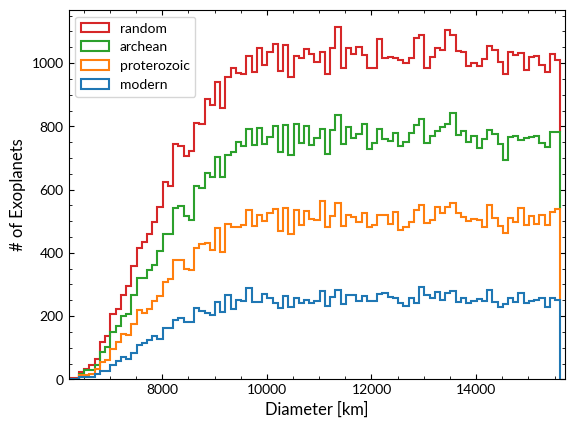

In [78]:
plothist("OBJECT-DIAMETER", "Diameter [km]", 100)

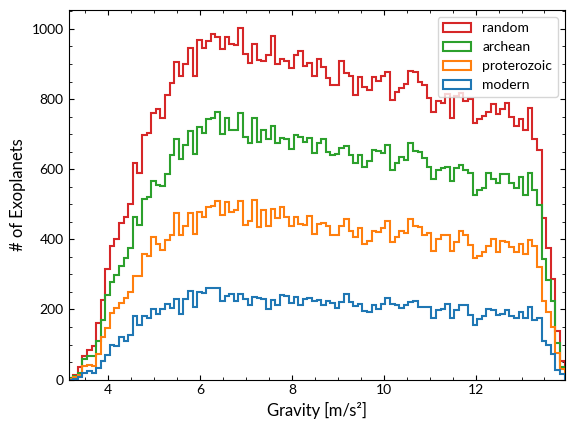

In [79]:
plothist("OBJECT-GRAVITY", "Gravity [m/s²]", 0.1)

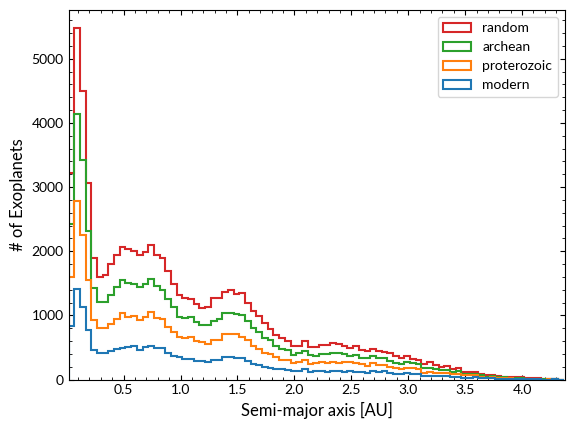

In [83]:
plothist("OBJECT-STAR-DISTANCE", "Semi-major axis [AU]", 0.05)

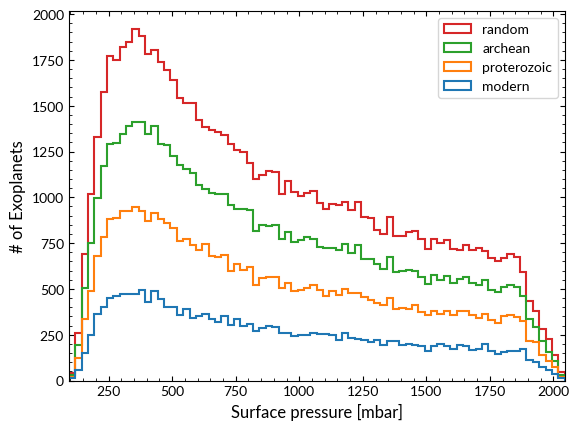

In [90]:
plothist("ATMOSPHERE-PRESSURE", "Surface pressure [mbar]", 25)

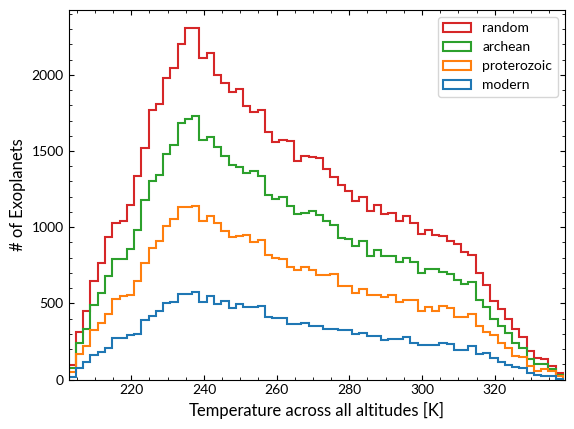

In [96]:
plothist("ATMOSPHERE-TEMPERATURE", "Temperature across all altitudes [K]", 2)

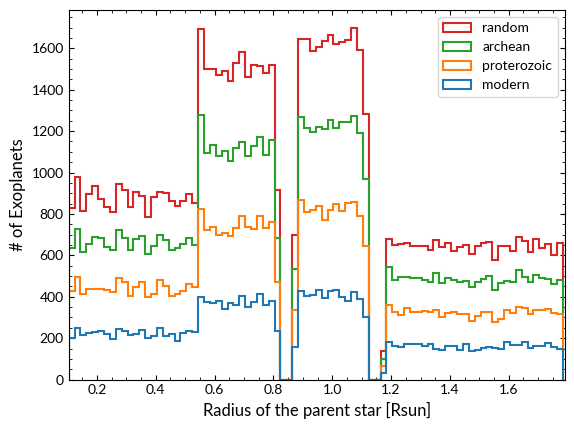

In [101]:
plothist("OBJECT-STAR-RADIUS", "Radius of the parent star [Rsun]", 0.02)

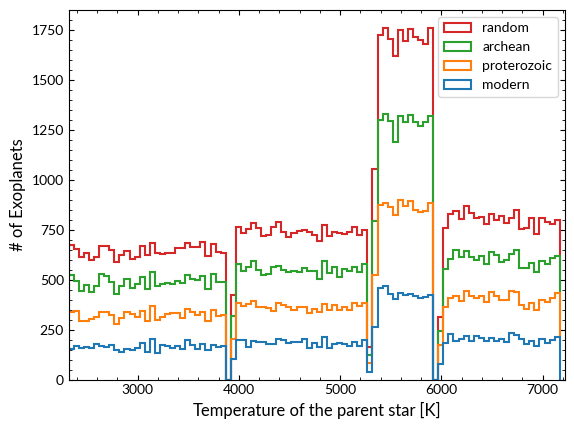

In [104]:
plothist("OBJECT-STAR-TEMPERATURE", "Temperature of the parent star [K]", 50)

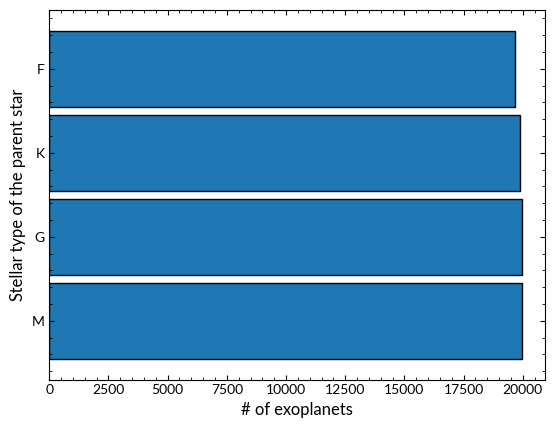

In [86]:
df["OBJECT-STAR-TYPE"].value_counts().plot(kind="barh", grid=False, ec="k", width=0.9)
plt.xticks(rotation=0)
plt.ylabel("Stellar type of the parent star"), plt.xlabel("# of exoplanets");

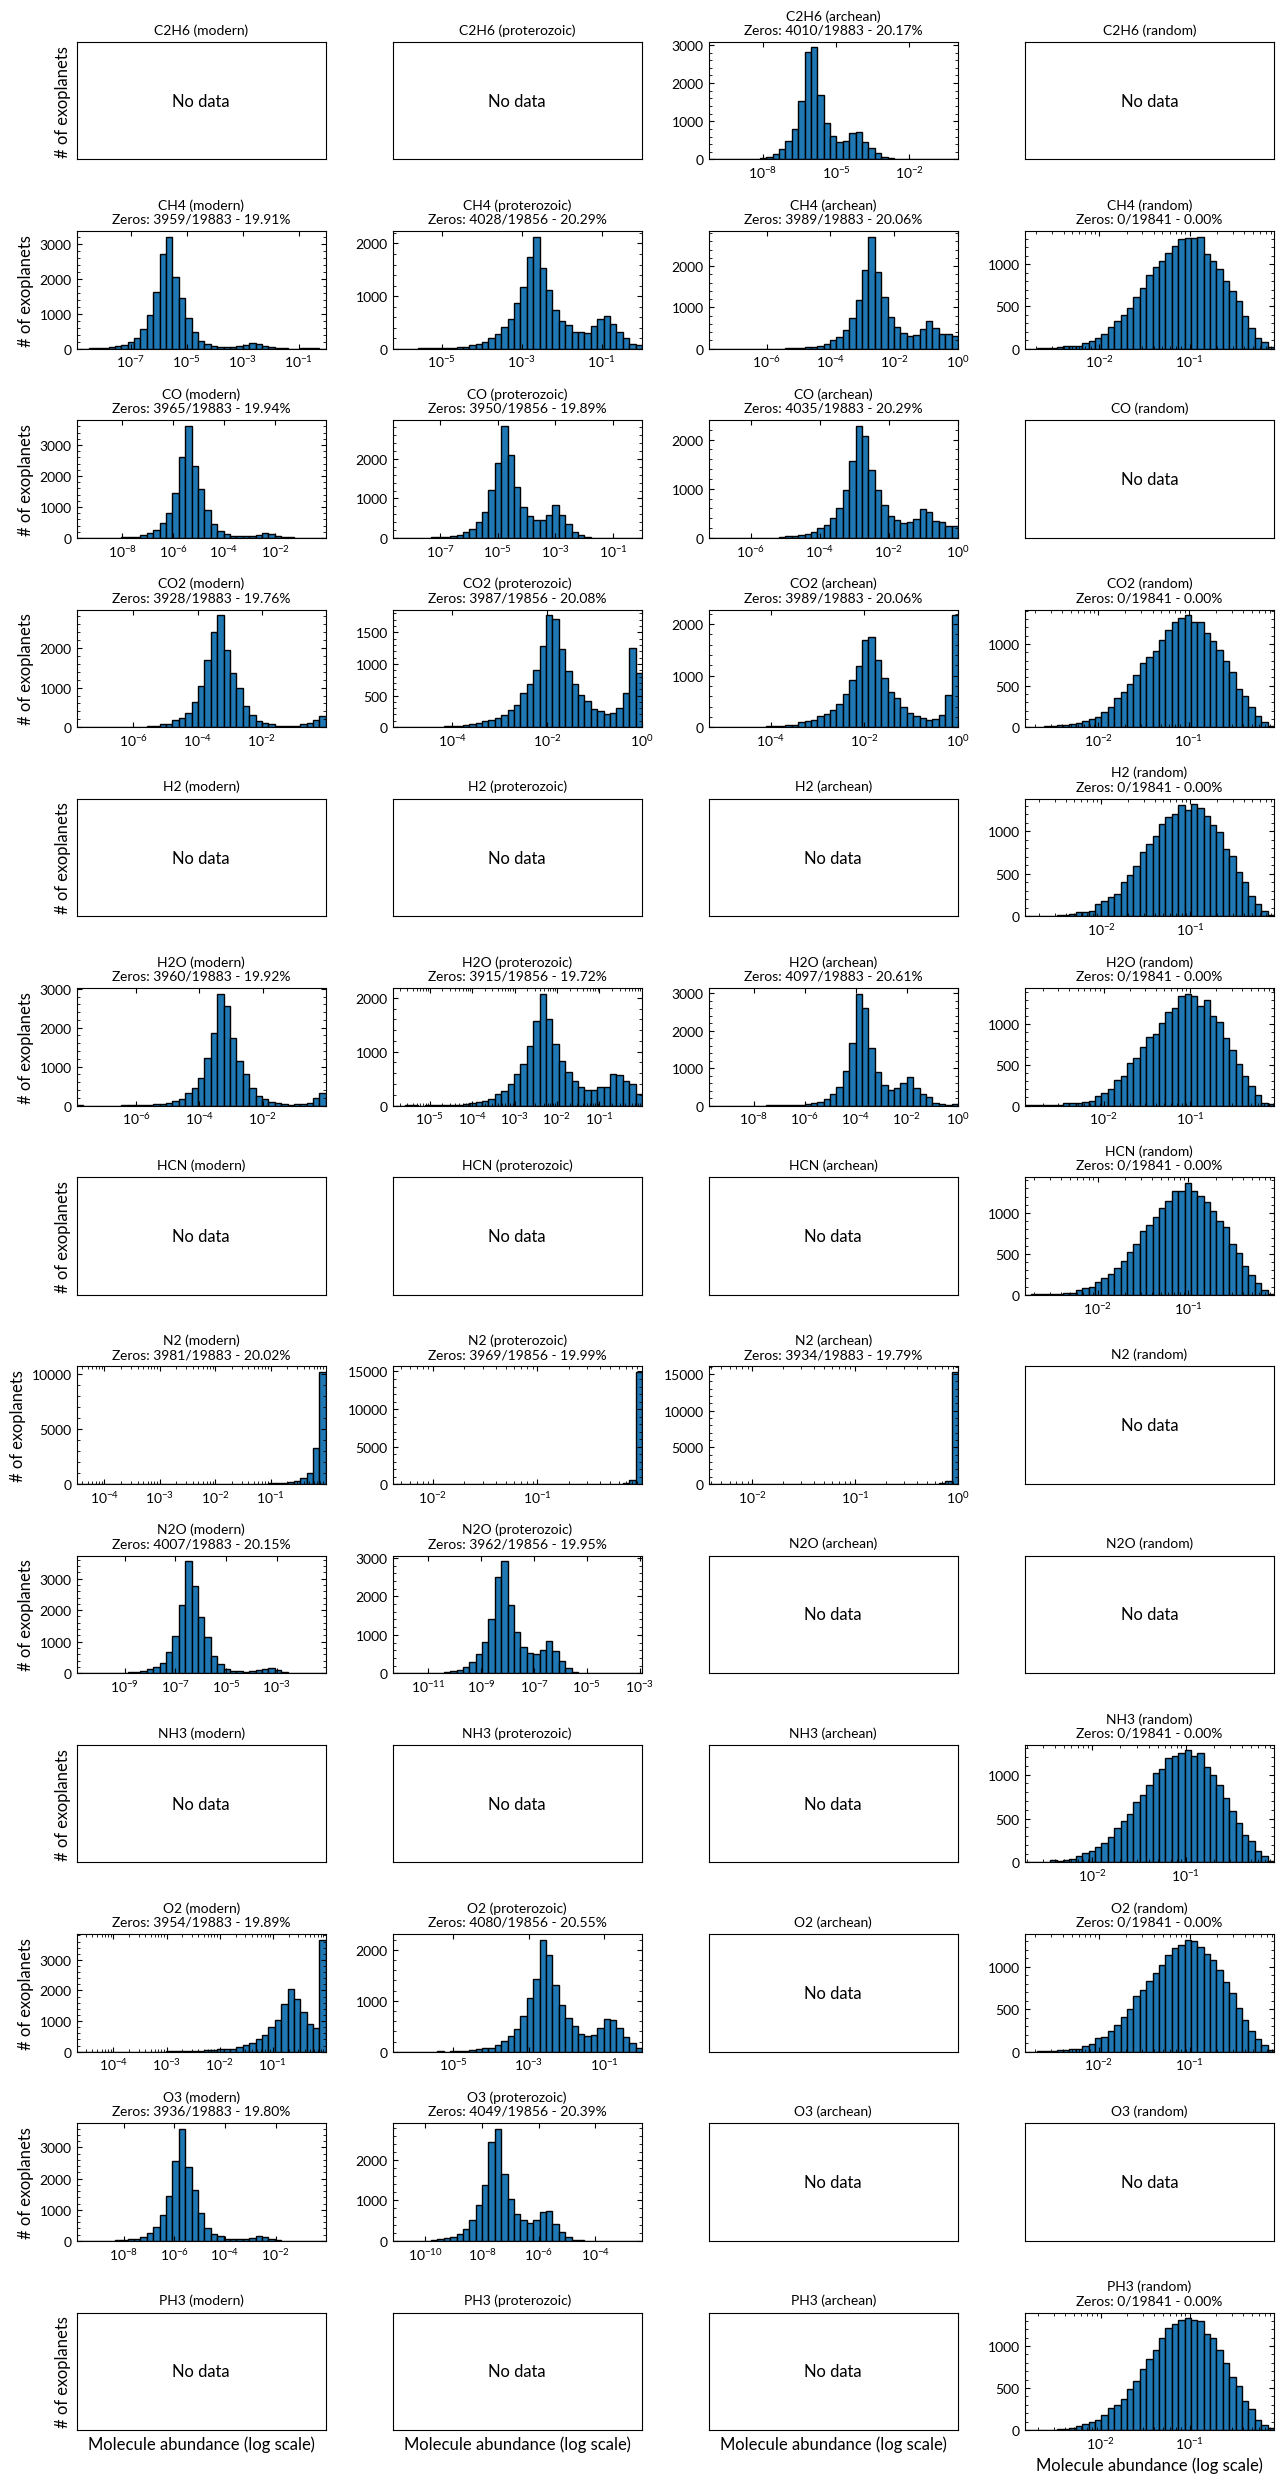

In [124]:
unique_molecules = set(
    ",".join(df["ATMOSPHERE-LAYERS-MOLECULES"].dropna().unique()).split(",")
)

earth_types = df["Earth_type"].unique()

fig, axes = plt.subplots(len(unique_molecules), len(earth_types), figsize=(13, 25))
axes = np.atleast_2d(axes)

for i, molecule in enumerate(sorted(unique_molecules)):
    for j, earth_type in enumerate(earth_types):
        ax = axes[i, j]
        
        # Filter data for the current molecule and Earth type
        subset = df[(df["Earth_type"] == earth_type) & (df[molecule].notna())] if molecule in df.columns else None
        if subset is not None and not subset.empty:
            data = subset[molecule]
        else:
            data = None

        if data is not None:
            # Compute zero percentages
            zero_count = (data == 0).sum()
            total_count = len(data)
            zero_percentage = (zero_count / total_count) * 100 if total_count > 0 else 0

            # Define non-zero data and log-scale bins
            non_zero_data = data[data > 0]
            if len(non_zero_data) > 0:
                bins = np.logspace(
                    np.log10(non_zero_data.min()), np.log10(non_zero_data.max()), 40
                )
                ax.hist(non_zero_data, bins=bins, edgecolor="k")
                ax.set_xscale("log")
                ax.set_xlim(non_zero_data.min(), non_zero_data.max())
                
                # Set titles and labels
                ax.set_title(
                    f"{molecule} ({earth_type})\nZeros: {zero_count}/{total_count} - {zero_percentage:.2f}%",
                    fontsize=10,
                )
            else:
                ax.text(0.5, 0.5, "No data", ha="center", va="center", transform=ax.transAxes)
                ax.set_xticks([])
                ax.set_yticks([])

                # Set titles and labels
                ax.set_title(f"{molecule} ({earth_type})",fontsize=10)
        else:
            ax.text(0.5, 0.5, f"No data for {molecule} ({earth_type})", ha="center", va="center", transform=ax.transAxes)

        if j == 0:
            ax.set_ylabel("# of exoplanets")
        if i == len(unique_molecules) - 1:
            ax.set_xlabel("Molecule abundance (log scale)")

fig.tight_layout()
fig.savefig("distribution.pdf", bbox_inches='tight');